<a href="https://colab.research.google.com/github/cromi0256/Study01/blob/main/17%EC%9E%A5_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

            전일대비증감수
날짜                 
2021-01-01      357
2021-01-02      250
2021-01-03      198
2021-01-04      329
2021-01-05      199
           전일대비증감수
count   365.000000
mean    565.200000
std     633.007991
min      79.000000
25%     159.000000
50%     320.000000
75%     660.000000
max    3166.000000


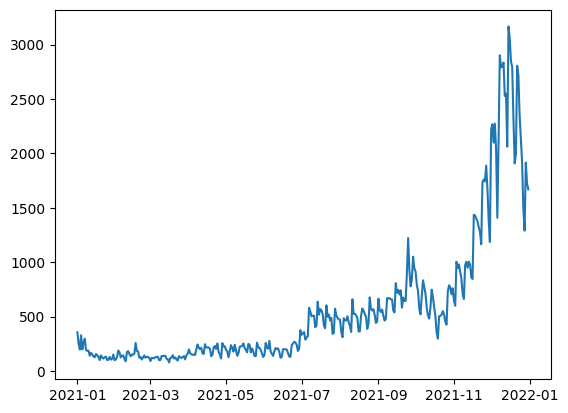

In [1]:
#17-1 시계열 EDA
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
ts=pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv',encoding='utf-8').filter(['날짜','전일대비증감수'])
ts['날짜']=pd.to_datetime(ts['날짜'])
ts=ts.set_index('날짜')
print(ts.head())
print(ts.describe())

plt.plot(ts)
plt.show()

#데이터 분할
ts_head=ts.head(334)
ts_tail=ts.tail(31)

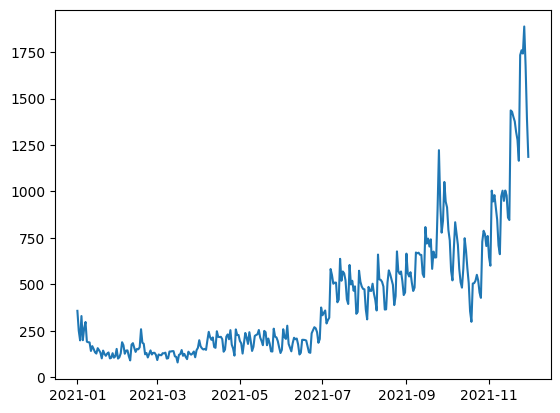

ADF Statistic: 0.762314
p-value: 0.991003


In [2]:
#정상성 확인 : 시간에 따라 평균과 분산이 일정하며, 추세나 계절성이 없음
#ADF
#H0:단위근을 포함한다(비정상 시계열)  / H1:단위근을 포함하지 않는다(정상 시계열)
from statsmodels.tsa.stattools import adfuller
plt.plot(ts_head) #1월~11월 데이터
plt.show()
result=adfuller(ts_head,regression='c',autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])  #귀무가설을 지지하며 비정상 시계열임

In [3]:
#KPSS
#H0:정상시계열이다  / H1:비정상 시계열이다
from statsmodels.tsa.stattools import kpss
result=kpss(ts_head,regression='c',nlags='auto')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])  #대립가설을 지지하므로 비정상 시계열이다

KPSS Statistic: 2.209819
p-value: 0.010000


<ipython-input-3-482fc5fe9d8d>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result=kpss(ts_head,regression='c',nlags='auto')


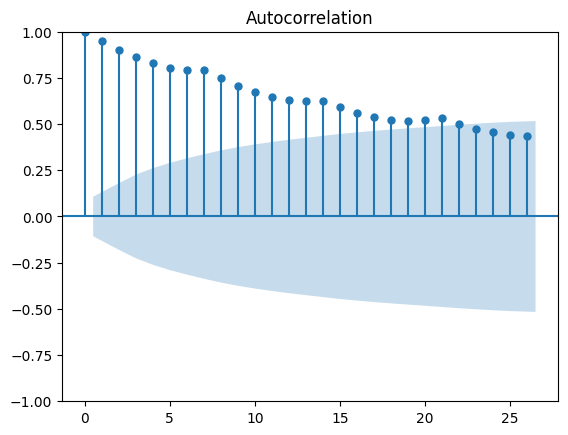

In [4]:
#ACF 그래프
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_head)
plt.show()
#시차에 따라 값이 빠르게 떨어지지 않으므로 비정상 시계열이다

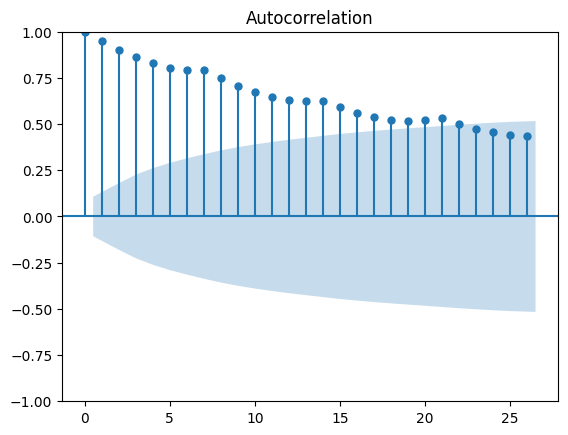

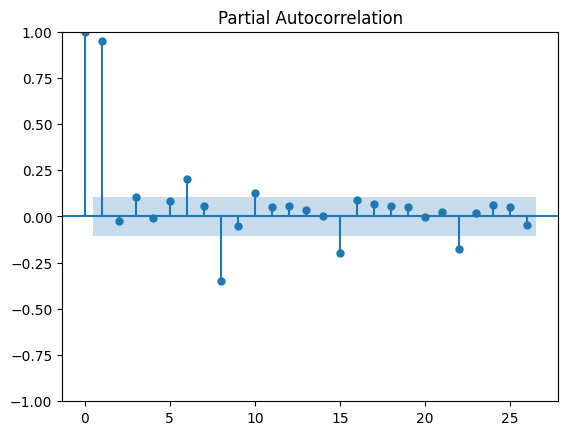

In [5]:
#자기상관 확인:서로 다른 시점의 데이터간 선형적 상관관계
#ACF/PACF 그래프
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf,pacf
plot_acf(ts_head)
plt.show()
plot_pacf(ts_head)
plt.show()
#ACF그래프의 임계영역을 벗어나는 값이 존재
#PACF 그래프의 임계염역을 벗어나는 시차 존재
#>자기상관이 있다

In [6]:
#융-박스 검정
#H0:데이터가 일련의 상관관계를 나타내지 않는다  / H1:데이터가 일련의 상관관계를 나타낸다(자기상관이 있다)
from statsmodels.stats.diagnostic import acorr_ljungbox
result=acorr_ljungbox(ts_head,auto_lag=True).head(5)
print(result)

       lb_stat      lb_pvalue
1   304.691106   3.131578e-68
2   579.605498  1.381228e-126
3   833.394832  2.474556e-180
4  1067.333259  9.111938e-230
5  1286.641140  5.005454e-276


In [7]:
#더빗왓슨 검정
#0이나 4에 가까울수록 자기 상관이 있다
from statsmodels.stats.stattools import durbin_watson
result=durbin_watson(ts_head)
print(result)

[0.03337102]


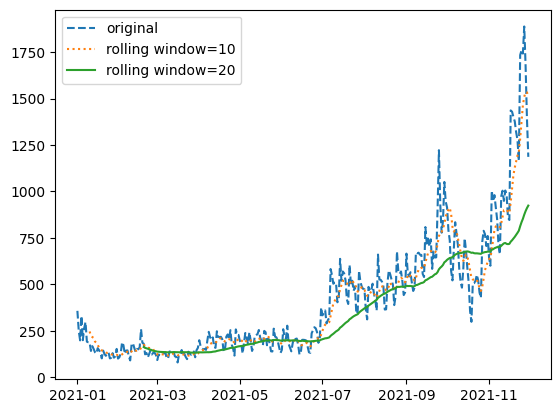

In [8]:
#시계열 분해
#이동평균법:일정 기간의 이동평균을 계산하여 계절변동과 불규칙 변동 제거
titles=['original','rolling window=10','rolling window=20']
rw10=ts_head.rolling(window=10).mean().dropna()
rw50=ts_head.rolling(window=50).mean().dropna()
data_list=[ts_head,rw10,rw50]
ls_list=['dashed','dotted','solid']

for title,data,ls in zip(titles,data_list,ls_list):
  plt.plot(data,label=title,linestyle=ls)
plt.legend(loc='best')
plt.show()

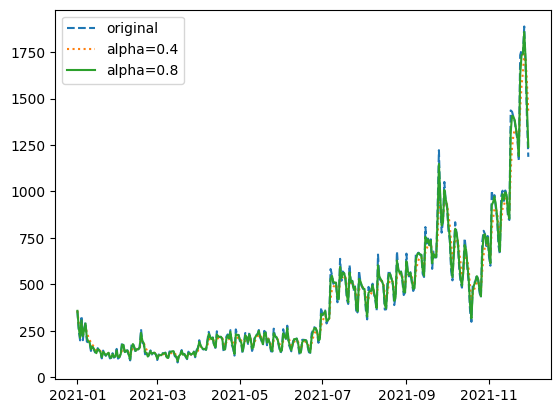

In [9]:
#지수평활법:모든 시계열 자료의 평균을 구하며 최신 시계열에 더 큰 가중치를 부여
titles=['original','alpha=0.4','alpha=0.8']
ewm04=ts_head.ewm(alpha=0.4).mean()
ewm08=ts_head.ewm(alpha=0.8).mean()
data_list=[ts_head,ewm04,ewm08]
ls_list=['dashed','dotted','solid']

for title,data,ls in zip(titles,data_list,ls_list):
  plt.plot(data,label=title,linestyle=ls)
plt.legend(loc='best')
plt.show()

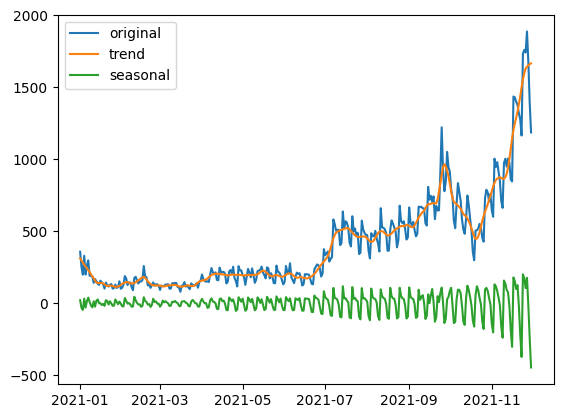

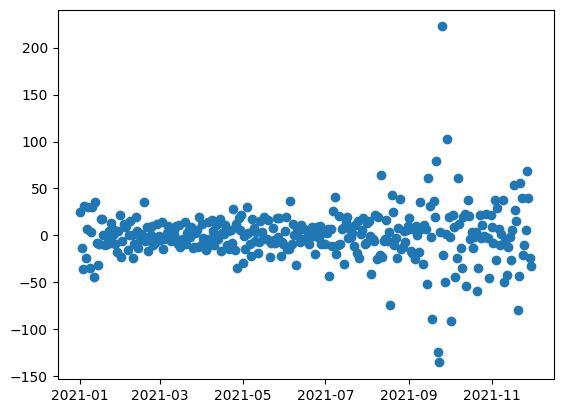

In [10]:
#STL 분해
from statsmodels.tsa.seasonal import STL
fitted=STL(ts_head,seasonal=7,trend=9).fit()
resid=fitted.resid
seasonal=fitted.seasonal
trend=fitted.trend

titles=['original','trend','seasonal','resid']
data_list=[ts_head,trend,seasonal,resid]

for title,data,ls in zip(titles,data_list,ls_list):
  plt.plot(data,label=title)
plt.legend(loc='best')
plt.show()

plt.scatter(data.index,resid)
plt.show()

In [11]:
#17-2 시계열 데이터 전처리
ts=pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv',encoding='utf-8').filter(['날짜','전일대비증감수'])

print(ts.head())
print(ts['날짜'].dtypes)
#object > datetime
ts['날짜']=ts['날짜'].astype('datetime64[ns]')
print(ts['날짜'].dtypes)

         날짜  전일대비증감수
0  2021.1.1      357
1  2021.1.2      250
2  2021.1.3      198
3  2021.1.4      329
4  2021.1.5      199
object
datetime64[ns]


In [12]:
#string > datetime
import datetime as dt
import time
string='2025-12-25 12:25:00'
datetime=dt.datetime.strptime(string,'%Y-%m-%d %H:%M:%S')
print('변환전 타입:',type(string))
print('변환후 타입:',type(datetime))

#datetime > string
string2=datetime.strftime('%Y-%m-%d %H:%M:%S')
print('문자열화:',type(string2))

변환전 타입: <class 'str'>
변환후 타입: <class 'datetime.datetime'>
문자열화: <class 'str'>


In [13]:
#timestamp - datetime
#dt.datetime.fromtimestamp(타임스탬프)
#time.mktime(데이트타임.timetuple())

In [14]:
#날짜데이터 생성 - dt.datetime
date1=dt.datetime(2025,1,27,4,5,6)
#연,월,일 / 시,분,초
date2=dt.datetime.now()
d1=dt.date(2024,12,31)
t1=dt.time(20,24,59)
print('현재시간:',date2)

현재시간: 2025-01-28 22:04:17.439135


In [15]:
#날짜데이터 생성 - pd.date_range, pd.period_range
date_list=pd.date_range(start=dt.date.today(),periods=7,freq='2D')
#시작날짜 / 종료날짜 / 날짜수 / 간격('A':년, 'M':월, 'D':일, 'T(min)':분, 'S':초, 'Q':분기, 'W':주)
print(date_list)

DatetimeIndex(['2025-01-28', '2025-01-30', '2025-02-01', '2025-02-03',
               '2025-02-05', '2025-02-07', '2025-02-09'],
              dtype='datetime64[ns]', freq='2D')


In [16]:
#날짜데이터 포맷 변경
date3=date1.strftime('%Y-%m-%d')
print(date3)
print(type(date3))

date4=date1.strftime('%y년 %m월 %d일')
print(date4)

2025-01-27
<class 'str'>
25년 01월 27일


In [17]:
 #날짜데이터 값 수정
 date5=date1.replace(year=2024)
 #year,month,day,hour,minute,second
 print(date5)

2024-01-27 04:05:06


In [18]:
#날짜데이터 값 병합
dt1=dt.datetime.combine(d1,t1)
print(dt1)

2024-12-31 20:24:59


In [19]:
#날짜데이터 연산
day10=dt.timedelta(days=10)
print(date5)
print('10일 전',date5-day10)
print('10일 후',date5+day10)

2024-01-27 04:05:06
10일 전 2024-01-17 04:05:06
10일 후 2024-02-06 04:05:06


In [20]:
#날짜데이터 추출
print(date5.year)
print(date5.month)
print(date5.day)

weekday=date5.weekday() #0~6(월요일~일요일)
print(weekday)
day_name=date5.strftime('%A')
print(day_name)

2024
1
27
5
Saturday


In [21]:
#시계열 리샘플링
ts=pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/\
main/12_covid19.csv',encoding='utf-8')
ts['날짜']=pd.to_datetime(ts['날짜'])
ts=ts.set_index('날짜')
print(ts)

            누적확진자수  전일대비증감수
날짜                         
2021-01-01   19352      357
2021-01-02   19602      250
2021-01-03   19800      198
2021-01-04   20129      329
2021-01-05   20328      199
...            ...      ...
2021-12-27  218646     1496
2021-12-28  219934     1290
2021-12-29  221847     1915
2021-12-30  223567     1722
2021-12-31  225235     1670

[365 rows x 2 columns]


In [22]:
#rule,aggreating
print(ts.resample(rule='2ME').asfreq())  #대표날짜
print(ts.resample(rule='2ME').sum()) #데이터 합
print(ts.resample(rule='2M').mean()) #데이터 평균

              누적확진자수  전일대비증감수
날짜                           
2021-01-31   24155.0    100.0
2021-03-31   32029.0    158.0
2021-05-31   43914.0    130.0
2021-07-31   64350.0    475.0
2021-09-30  100492.0    945.0
2021-11-30  154286.0   1186.0
2022-01-31       NaN      NaN
             누적확진자수  전일대비증감수
날짜                          
2021-01-31   686200     5160
2021-03-31  1670875     7874
2021-05-31  2319244    11885
2021-07-31  3177813    20436
2021-09-30  4902606    36144
2021-11-30  7480386    53822
2022-01-31  5960209    70977
                   누적확진자수      전일대비증감수
날짜                                    
2021-01-31   22135.483871   166.451613
2021-03-31   28319.915254   133.457627
2021-05-31   38020.393443   194.836066
2021-07-31   52095.295082   335.016393
2021-09-30   80370.590164   592.524590
2021-11-30  122629.278689   882.327869
2022-01-31  192264.806452  2289.580645


<ipython-input-22-9f740662ac41>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  print(ts.resample(rule='2M').mean()) #데이터 평균


In [23]:
#결측치 처리
#bfill, ffill 이전,이후 값으로 대치
'''interpolate(method='linear'선형보간
                      'quadratic'2차 스플라인 보간
                      'cubic'3차 스플라인 보간)
'''

"interpolate(method='linear'선형보간\n                      'quadratic'2차 스플라인 보간\n                      'cubic'3차 스플라인 보간)\n"

<ipython-input-28-11bd49c5289b>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp=kpss(data)[1]
<ipython-input-28-11bd49c5289b>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp=kpss(data)[1]
<ipython-input-28-11bd49c5289b>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp=kpss(data)[1]


original: ADF p-value 0.991, KPSS p-value 0.010
diff(1): ADF p-value 0.004, KPSS p-value 0.100
diff(2): ADF p-value 0.005, KPSS p-value 0.100


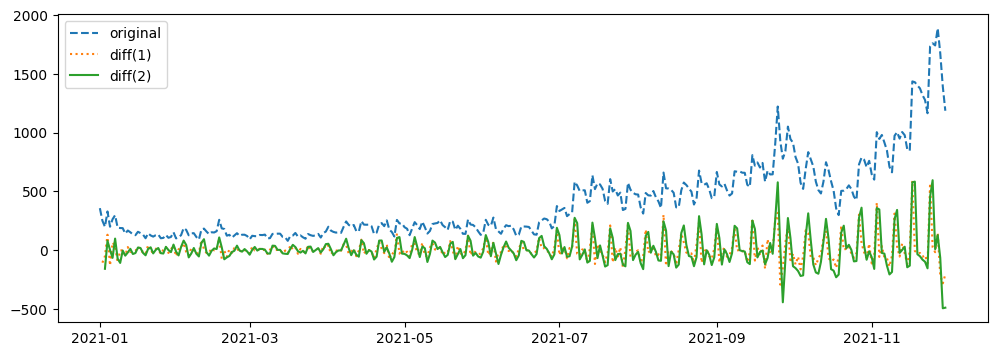

In [28]:
#차분과 변환
fig, ax= plt.subplots(1,1,figsize=(12,4))

titles=['original','diff(1)','diff(2)']
diff1=ts_head.diff(periods=1).dropna()
diff2=ts_head.diff(periods=2).dropna()
data_list=[ts_head,diff1,diff2]
ls_list=['dashed','dotted','solid']

for title,data,ls in zip(titles,data_list,ls_list):
  ax.plot(data,label=title,linestyle=ls)
  ap=adfuller(data)[1]
  kp=kpss(data)[1]
  print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title,ap,kp))
plt.legend()
plt.show()
#1번의 차분만으로도 정상 시계열이 되었다

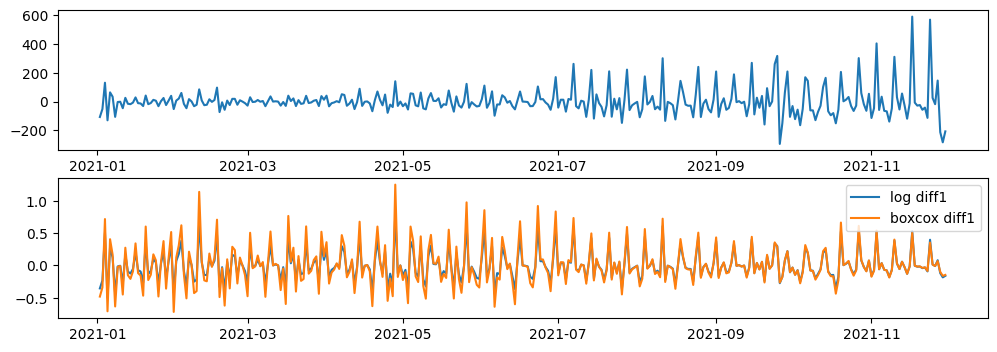

original: ADF p-value 0.991, KPSS p-value 0.010
log diff1: ADF p-value 0.001, KPSS p-value 0.100
boxcox diff1: ADF p-value 0.000, KPSS p-value 0.100


<ipython-input-33-8df602bd6df6>:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp=kpss(data)[1]
<ipython-input-33-8df602bd6df6>:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp=kpss(data)[1]
<ipython-input-33-8df602bd6df6>:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp=kpss(data)[1]


In [33]:
#변환(d)
import numpy as np
from sklearn.preprocessing import PowerTransformer
log=np.log(ts_head) #로그변환
pt=PowerTransformer(method='box-cox')
bc=pt.fit_transform(ts_head)
boxcox=pd.DataFrame(bc,index=ts_head.index,columns=ts_head.columns)
#차분 1회
log_diff1=log.diff(periods=1).dropna()
bc_diff1=boxcox.diff(periods=1).dropna()

#시각화
fig, ax= plt.subplots(2,1,figsize=(12,4))
ax[0].plot(ts_head.diff(1).dropna(),label='original')
ax[1].plot(log_diff1,label='log diff1')
ax[1].plot(bc_diff1,label='boxcox diff1')
plt.legend()
plt.show()

titles=['original','log diff1','boxcox diff1']
data_list=[ts_head,log_diff1,bc_diff1]

for title,data in zip(titles,data_list):
  ap=adfuller(data)[1]
  kp=kpss(data)[1]
  print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title,ap,kp))
#로그변환이나 박스콕스 변환으로 정상시계열이 되었다

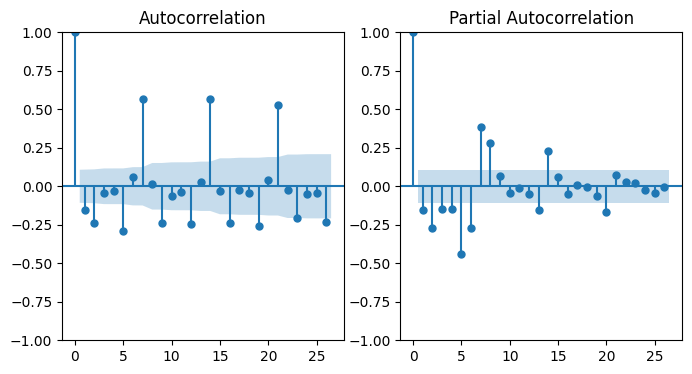

In [38]:
#17-3 시계열 모델링 및 평가
#박스-젠킨스 방법
#PACF그래프로 자기회귀(AR) p를 찾고
#ACF그래프로 이동평균(MA) q를 구한다
#계절성이 있는 경우 m을 고려하여 동일한 방법으로 P,D,Q를 구한다

fig,ax = plt.subplots(1,2,figsize=(8,4))
plot_acf(log_diff1,ax=ax[0])
plot_pacf(log_diff1,ax=ax[1])
plt.show()
#절단점을 참고하여 p=8, q=2로 정한다(주기(m)가 7인 계절성이 보인다)
p,d,q=8,1,2
P,D,Q,M=0,0,1,7 #계절성 계수 과정생략

In [44]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=ARIMA(ts_head,order=(p,d,q),seasonal_order=(P,D,Q,M))
model_fit=model.fit()
resid=model_fit.resid
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(8, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1853.942
Date:                           Tue, 28 Jan 2025   AIC                           3731.884
Time:                                   22:59:46   BIC                           3777.582
Sample:                               01-01-2021   HQIC                          3750.107
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0152      0.598      0.025      0.980      -1.157       1.187
ar.L2         -0.0211      0.035     -0.610

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
#예측 성능
from sklearn.metrics import r2_score,mean_absolute_percentage_error
pred1=model_fit.forecast(31)
r2=r2_score(ts_tail,pred1)
mape=mean_absolute_percentage_error(ts_tail,pred1)
print('R2: {:.3f}, MAPE: {:.3f}'.format(r2,mape))

R2: -1.393, MAPE: 0.262


In [48]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.8 MB/s eta 0:00:00


In [53]:
#auto ARIMA
from pmdarima import auto_arima
auto_arima(ts_head,start_p=2,start_q=2,max_p=10,max_q=5,
           start_P=0,start_Q=0,
           m=7,seasonal=True,suppress_warnings=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [55]:
model=ARIMA(ts_head,order=(3,1,0),seasonal_order=(1,0,1,7))
fitted=model.fit()
resid=fitted.resid
print(fitted.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                     
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1852.753
Date:                           Tue, 28 Jan 2025   AIC                           3717.507
Time:                                   23:21:25   BIC                           3740.355
Sample:                               01-01-2021   HQIC                          3726.618
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2260      0.036     -6.292      0.000      -0.296      -0.156
ar.L2         -0.1731      0.039     -4.395

In [56]:
pred2=fitted.forecast(31)
r2=r2_score(ts_tail,pred2)
mape=mean_absolute_percentage_error(ts_tail,pred2)

print('R2: {:.3f}, MAPE: {:.3f}'.format(r2,mape))

R2: -0.740, MAPE: 0.245


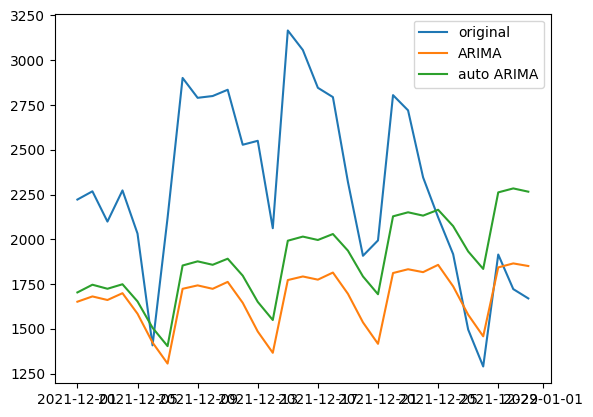

In [62]:
plt.plot(ts_tail,label='original')
plt.plot(pred1,label='ARIMA')
plt.plot(pred2,label='auto ARIMA')
plt.legend()
plt.show()

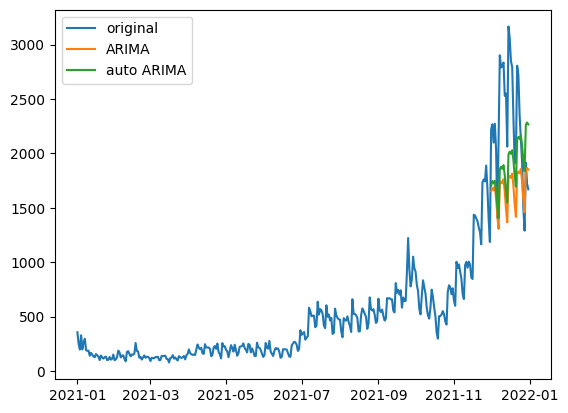

In [66]:
plt.plot(ts['전일대비증감수'],label='original')
plt.plot(pred1,label='ARIMA')
plt.plot(pred2,label='auto ARIMA')
plt.legend()
plt.show()